<a href="https://colab.research.google.com/github/mounikaduddukuri/S7/blob/master/trail1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cuda")
print(device)

cuda


In [0]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      #  transforms.RandomRotation((-11.0, 11.0)),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     #  transforms.RandomRotation((-11.0, 11.0)),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])





In [0]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False,download=True, transform=test_transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
print('No.of images in train set are',len(trainset))
print('No.of images in test set are',len(testset))

No.of images in train set are 50000
No.of images in test set are 10000


In [0]:
# CUDA?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cuda")
cuda = torch.cuda.is_available()

print(device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cuda


 deer   car  ship  bird


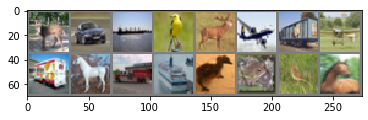

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
           
        ) 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
           
        )
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2, bias=False),
            nn.BatchNorm2d(128),
            
            nn.ReLU()
            
        ) 

        #Dilated kernel
        self.dilated =nn.Sequential(
             nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1, bias=False, dilation=2),
             nn.BatchNorm2d(64),
            
            nn.ReLU())

        #Depthwise kernal
        self.depthwise =nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3, padding=1, groups=1),
             nn.BatchNorm2d(64),
            
            nn.ReLU())
        
        #Convolution kernel
        self.lastcov = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
            
        ) 
        
        #GAP kernel
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) 
        #Fully connected layers
        self.fc1 = nn.Sequential(
                   nn.Linear(256*1*1, 1024)
                   )
        self.fc2 = nn.Sequential( nn.Linear(1024, 10))


       
    def forward(self, x):
      #input block
        x = self.convblock1(x) # output_size = 30 ,RF=3
        # print('after c1',x.shape)
      # C1 block
        x = self.convblock2(x) # output_size = 30 ,RF=5
        # print('after c2',x.shape)
      # Transision T1 block
        x = self.pool1(x)      # output_size = 15 ,RF=7  j=2
        # print('after 1 pool',x.shape)
        x = self.convblock5(x) # output_size = 17 ,RF=11  j=2
        # print('after 1poolconv',x.shape)
      # C2 block
        x = self.dilated(x) # output_size = 15 ,RF=19  j=4
        # print(x.shape)
      # Transision T2 block
        x = self.pool1(x)      # output_size = 7 ,RF=27  j=8
        # print(x.shape)
        x = self.convblock5(x) # output_size = 9 ,RF=43  j=8
        # print(x.shape)
      # C3 block
        x = self.depthwise(x)  # output_size = 9 ,RF=59  j=8
        # print(x.shape)
      # Transision T3 block
        x = self.pool1(x)      # output_size = 4 ,RF=75  j=16
        # print(x.shape)
        x = self.convblock5(x) # output_size = 6 ,RF=107  j=16
        # print(x.shape)
      # C4 block
        x = self.lastcov(x) # output_size = 6 ,RF=139
        # print(x.shape)
        x = self.gap(x)
        # print(x.shape)
        x = x.view(-1, 256*1*1)
        x = self.fc1(x)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)

        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 30, 30]          18,432
       BatchNorm2d-5           [-1, 64, 30, 30]             128
              ReLU-6           [-1, 64, 30, 30]               0
         MaxPool2d-7           [-1, 64, 15, 15]               0
            Conv2d-8          [-1, 128, 17, 17]          73,728
       BatchNorm2d-9          [-1, 128, 17, 17]             256
             ReLU-10          [-1, 128, 17, 17]               0
           Conv2d-11           [-1, 64, 15, 15]          73,728
      BatchNorm2d-12           [-1, 64, 15, 15]             128
             ReLU-13           [-1, 64, 15, 15]               0
        MaxPool2d-14             [-

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(trainloader)
  correct = 0
  processed = 0
  # for batch_idx, (data, target) in enumerate(pbar):
    # get samples
  for data, target in trainloader:
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    # pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
    test_acc.append(100. * correct / len(testloader.dataset))

In [0]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

  0%|          | 0/3125 [00:00<?, ?it/s]

EPOCH: 0



  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 1.2034, Accuracy: 5875/10000 (58.75%)

EPOCH: 1




  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.9218, Accuracy: 6785/10000 (67.85%)

EPOCH: 2





  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.7033, Accuracy: 7574/10000 (75.74%)

EPOCH: 3






  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6490, Accuracy: 7840/10000 (78.40%)

EPOCH: 4







  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.5887, Accuracy: 8007/10000 (80.07%)

EPOCH: 5








  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6026, Accuracy: 7998/10000 (79.98%)

EPOCH: 6









  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.5973, Accuracy: 8068/10000 (80.68%)

EPOCH: 7










  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.5714, Accuracy: 8176/10000 (81.76%)

EPOCH: 8











  0%|          | 0/3125 [00:00<?, ?it/s]


Test set: Average loss: 0.6007, Accuracy: 8051/10000 (80.51%)

EPOCH: 9

Test set: Average loss: 0.5949, Accuracy: 8184/10000 (81.84%)

